In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ISLP.svm import plot as plot_svm

## Data Preparation

In [60]:
df = pd.read_csv("Housing.csv")

In [61]:
# retrieve labels from https://usa.ipums.org/usa-action/variables/live_search for exploration purposes
col_labels = {
    "SERIAL": "Household serial number",
    "DENSITY": "Population-weighted density of PUMA",  # PUMA is Public Use Microdata Area
    "OWNERSHP": "Ownership of dwelling (tenure) [general version]",  # owned/being bought vs rented
    "OWNERSHPD": "Ownership of dwelling (tenure) [detailed version]",  # e.g. rented vs no cash rent vs cash rent
    "COSTELEC": "Annual electricity cost",
    "COSTGAS": "Annual gas cost",
    "COSTWATR": "Annual water cost",
    "COSTFUEL": "Annual home heating fuel cost",
    "HHINCOME": "Total household income",
    "VALUEH": "House value",
    "ROOMS": "Number of rooms",
    "BUILTYR2": "Age of structure, decade",
    "BEDROOMS": "Number of bedrooms",
    "VEHICLES": "Vehicles available",
    "NFAMS": "Number of families in household",
    "NCOUPLES": "Number of couples in household",
    "PERNUM": "Person number in sample unit",
    "PERWT": "Person weight",  # sampling weight, indicates how many persons in the U.S. population are represented by a given person
    "AGE": "Age",
    "MARST": "Marital status",
    "BIRTHYR": "Year of birth",
    "EDUC": "Educational attainment [general version]",
    "EDUCD": "Educational attainment [detailed version]",
    "INCTOT": "Total personal income",
}

df_readable = df.rename(columns=col_labels)

In [62]:
# filter by columns of interest and replace special missing values with NaN
cols_of_interest = [
    "Household serial number",
    "Population-weighted density of PUMA",
    "Ownership of dwelling (tenure) [general version]",
    "Number of rooms",
    "Age of structure, decade",
    "Number of bedrooms",
    "Number of families in household",
    "Number of couples in household",
    "Age",
    "Marital status",
    "Educational attainment [general version]",
    "Total personal income",
]

missing_values_per_col = {
    "Total personal income": [9999999],
}

df_filtered = df_readable[cols_of_interest].replace(missing_values_per_col, np.nan)

In [63]:
# rename some long column names
cols_rename_map = {
    "Population-weighted density of PUMA": "Population-weighted density",
    "Ownership of dwelling (tenure) [general version]": "Ownership of dwelling",
    "Educational attainment [general version]": "Educational attainment",
}

df_filtered = df_filtered.rename(columns=cols_rename_map)

In [64]:
# filter to single family households with 0 or 1 couples -- 2 or 3 couples of the same family living in the same household is an outlier.
df_single_family = df_filtered[
    (df_filtered["Number of families in household"] == 1)
    & (
        (df_filtered["Number of couples in household"] == 1)
        | (df_filtered["Number of couples in household"] == 0)
    )
]

# remove all rows with missing values
initial_length = len(df_single_family)
df_single_family = df_single_family.dropna()
new_length = len(df_single_family)
rows_dropped = initial_length - new_length
print(f"Removed {rows_dropped} rows with missing values out of {initial_length} ({(rows_dropped / initial_length)*100:.2f}%)")

# aggregate per head of household, defined as a person 18 or older with highest personal income
index = (
    df_single_family[df_single_family["Age"] >= 18]
    .groupby("Household serial number")["Total personal income"]
    .idxmax()
)
df_single_family = df_single_family.loc[index]

# we can also aggregate by sorting, but seems like a bad approach
# df_single_family = df_single_family.sort_values("Total personal income", ascending=False).drop_duplicates("Household serial number")

# drop Number of families in household since it's always 1
# drop Household serial number since we've already aggregated, and it's not useful as a predictor
df_single_family = df_single_family.drop(columns=["Number of families in household", "Household serial number"])

Removed 11840 rows with missing values out of 68131 (17.38%)


In [65]:
# group education into 5 categories: less than high school, high school, some college, bachelor's, graduate
# by default is (], left-exclusive and right-inclusive
bins = [0, 5, 6, 9, 10, 11]
labels = [
    "Less than high school",
    "High school",
    "Some college",
    "Bachelor's",
    "Graduate",
]
df_single_family["Educational attainment"] = pd.cut(
    df_single_family["Educational attainment"],
    bins=bins,
    labels=labels,
    include_lowest=True,  # so 0 is included in 0-5
)

In [66]:
# group marital status into 3 categories: married (spouse present/absent), previously married (separated/divorced/widowed), never married
bins = [1, 2, 5, 6]
labels = [
    "Married",
    "Previously married",
    "Never married",
]
df_single_family["Marital status"] = pd.cut(
    df_single_family["Marital status"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

In [67]:
# rename ownership of dwelling categories, 1 is Owned or being bought, 2 is Rented
df_single_family = df_single_family.replace(
    {"Ownership of dwelling": {1: "Owned", 2: "Rented"}}
)

In [68]:
# encode categorical predictors as nominal, the distance betweeen our categories is hard to quantify and may not be equal
# e.g. would distance between "Less than high school" and "High school" be the same as "High school" and "Some college"?
nominal_cols = [
    "Educational attainment",
    "Marital status",
]

# one-hot encode (which is different to dummy encode) - doesn't drop first category, easier to interpret and SVM can handle it
df_onehot = pd.get_dummies(df_single_family[nominal_cols], drop_first=False)
df_single_family = pd.concat([df_single_family, df_onehot], axis=1)
df_single_family = df_single_family.drop(columns=nominal_cols)

In [69]:
# group age into 3 categories: 18-34 (young adults), 35-64 (middle-aged adults), 65+ (older adults)
bins = [18, 34, 64, float('inf')]
labels = ["Young adults", "Middle-aged adults", "Older adults"]
# keep age as original data for later
age_groups = pd.cut(
    df_single_family["Age"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# create 3 separate dataframes for each age group
df_young_adults = df_single_family[age_groups == "Young adults"]
df_middle_aged_adults = df_single_family[age_groups == "Middle-aged adults"]
df_older_adults = df_single_family[age_groups == "Older adults"]

In [70]:
# scaler for later use 
scaler = StandardScaler()

## Modeling

### Young Adults

In [71]:
X = df_young_adults.drop(columns=['Ownership of dwelling'])
y = df_young_adults['Ownership of dwelling']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Radial

In [72]:
svm_rbf = SVC(kernel="rbf", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.0001, 0.001, 0.01, 1, 10, 100]}
cv = GridSearchCV(
    svm_rbf,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_rbf = cv.best_params_["C"]
best_gamma = cv.best_params_["gamma"]
print(f"Radial CV results: C={best_C_rbf}, gamma={best_gamma}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Radial CV results: C=10, gamma=0.01
Train accuracy: 80.52%
Test accuracy: 79.76%


#### Poly

In [73]:
svm_poly = SVC(kernel="poly", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "degree": np.arange(2, 5, 1),
    "coef0": np.arange(0, 3, 0.5),
}
cv = GridSearchCV(
    svm_poly,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_poly = cv.best_params_["C"]
best_degree = cv.best_params_["degree"]
best_coef0 = cv.best_params_["coef0"]

print(f"Poly CV results: C={best_C_poly}, degree={best_degree}, coef0={best_coef0}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Poly CV results: C=0.1, degree=2, coef0=1.5
Train accuracy: 80.19%
Test accuracy: 79.69%


#### Linear

In [74]:
svm_linear = SVC(kernel="linear", tol=0.1) 

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10]}
cv = GridSearchCV(
    svm_linear,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_linear = cv.best_params_["C"]

print(f"Linear CV results: C={best_C_linear}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Linear CV results: C=0.1
Train accuracy: 78.96%
Test accuracy: 79.20%


#### Feature Importance

In [75]:
coef = cv.best_estimator_.coef_[0]  # using linear kernel
feature_importances = pd.DataFrame({"Feature": X.columns, "Coefficient": coef, "AbsCoefficient": abs(coef)})
sorted_importances = feature_importances.sort_values(by="AbsCoefficient", ascending=False)

# sum up importances of onehot encoded features
grouped_importances = feature_importances.groupby(
    feature_importances["Feature"].str.split("_").str[0]
).sum()
sorted_grouped_importances = grouped_importances.sort_values(by="AbsCoefficient", ascending=False)

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_84534/2379649311.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_importances = feature_importances.groupby(


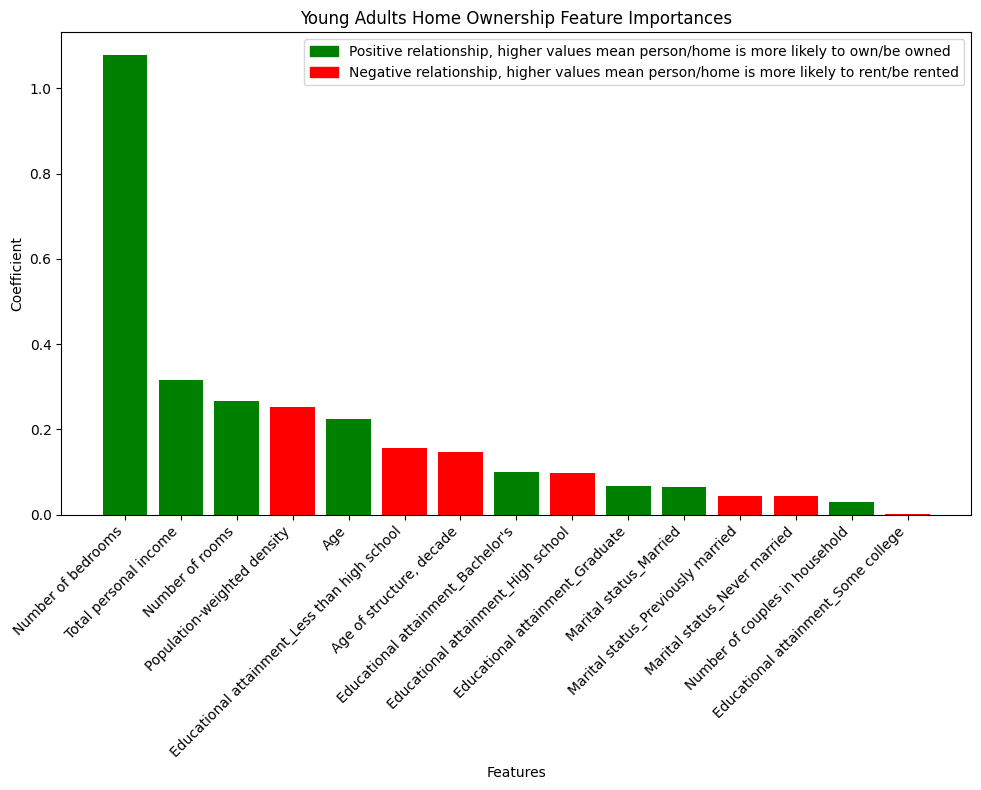

In [76]:
# color the bars based on coefficient sign
colors = ['green' if coef < 0 else 'red' for coef in sorted_importances["Coefficient"]]
green_patch = mpatches.Patch(color='green', label='Positive relationship, higher values mean person/home is more likely to own/be owned')
red_patch = mpatches.Patch(color='red', label='Negative relationship, higher values mean person/home is more likely to rent/be rented')

plt.figure(figsize=(10, 8))
plt.bar(sorted_importances['Feature'], sorted_importances["AbsCoefficient"], color=colors)
plt.legend(handles=[green_patch, red_patch])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Young Adults Home Ownership Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

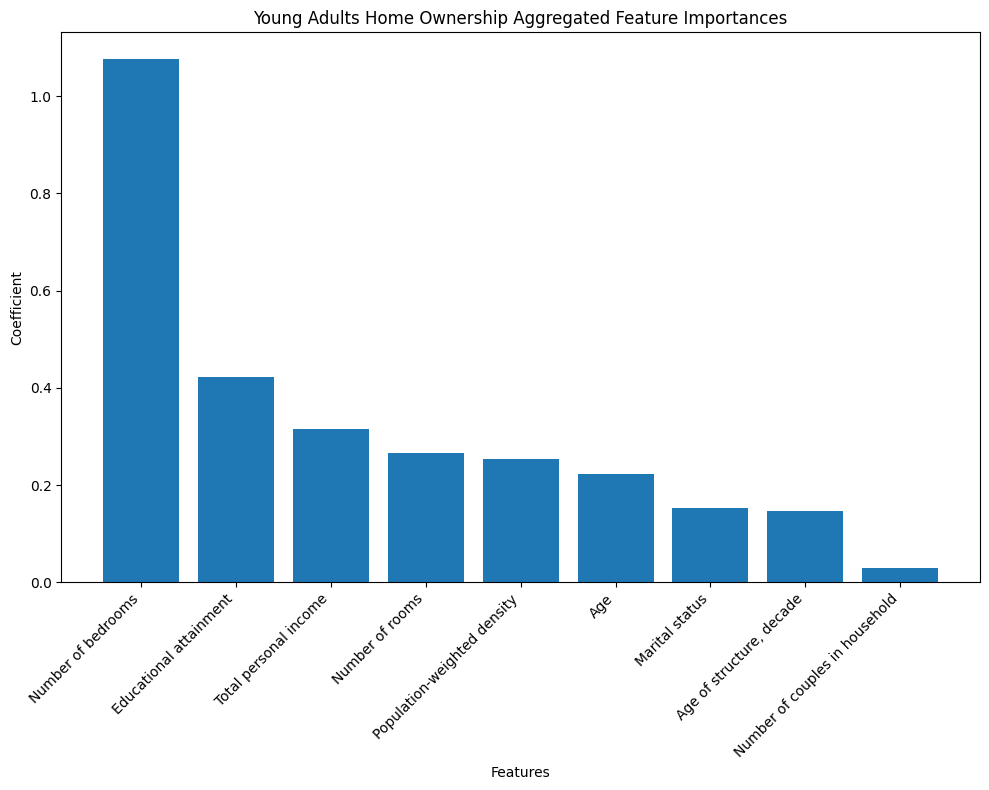

In [77]:
plt.figure(figsize=(10, 8))
plt.bar(sorted_grouped_importances.index, sorted_grouped_importances["AbsCoefficient"])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Young Adults Home Ownership Aggregated Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Middle-Aged Adults

In [78]:
X = df_middle_aged_adults.drop(columns=['Ownership of dwelling'])
y = df_middle_aged_adults['Ownership of dwelling']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Radial

In [79]:
svm_rbf = SVC(kernel="rbf", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.0001, 0.001, 0.01, 1, 10, 100]}
cv = GridSearchCV(
    svm_rbf,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_rbf = cv.best_params_["C"]
best_gamma = cv.best_params_["gamma"]
print(f"Radial CV results: C={best_C_rbf}, gamma={best_gamma}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Radial CV results: C=10, gamma=0.001
Train accuracy: 82.09%
Test accuracy: 82.59%


#### Poly

In [80]:
svm_poly = SVC(kernel="poly", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "degree": np.arange(2, 5, 1),
    "coef0": np.arange(0, 3, 0.5),
}
cv = GridSearchCV(
    svm_poly,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_poly = cv.best_params_["C"]
best_degree = cv.best_params_["degree"]
best_coef0 = cv.best_params_["coef0"]

print(f"Poly CV results: C={best_C_poly}, degree={best_degree}, coef0={best_coef0}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Poly CV results: C=10, degree=2, coef0=0.5
Train accuracy: 82.31%
Test accuracy: 82.87%


#### Linear

In [81]:
svm_linear = SVC(kernel="linear", tol=0.1) 

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10]}
cv = GridSearchCV(
    svm_linear,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_linear = cv.best_params_["C"]

print(f"Linear CV results: C={best_C_linear}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Linear CV results: C=1
Train accuracy: 82.22%
Test accuracy: 82.61%


#### Feature Importance

In [82]:
coef = cv.best_estimator_.coef_[0]  # using linear kernel
feature_importances = pd.DataFrame({"Feature": X.columns, "Coefficient": coef, "AbsCoefficient": abs(coef)})
sorted_importances = feature_importances.sort_values(by="AbsCoefficient", ascending=False)

# sum up importances of onehot encoded features
grouped_importances = feature_importances.groupby(
    feature_importances["Feature"].str.split("_").str[0]
).sum()
sorted_grouped_importances = grouped_importances.sort_values(by="AbsCoefficient", ascending=False)

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_84534/2379649311.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_importances = feature_importances.groupby(


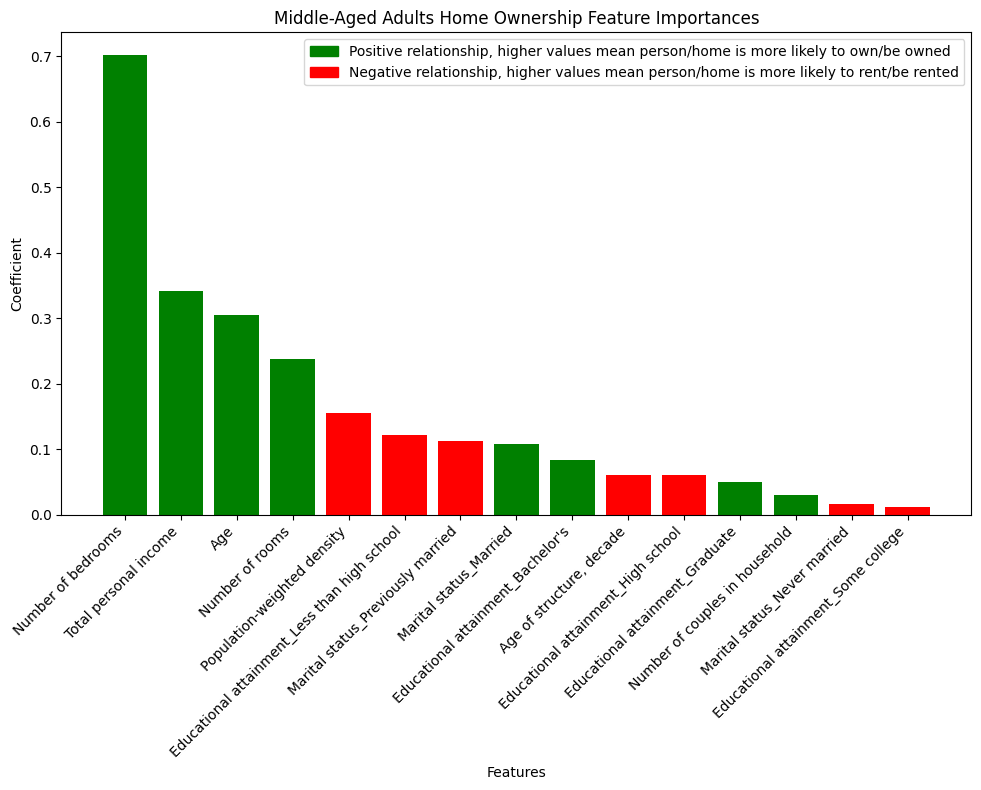

In [83]:
# color the bars based on coefficient sign
colors = ['green' if coef < 0 else 'red' for coef in sorted_importances["Coefficient"]]
green_patch = mpatches.Patch(color='green', label='Positive relationship, higher values mean person/home is more likely to own/be owned')
red_patch = mpatches.Patch(color='red', label='Negative relationship, higher values mean person/home is more likely to rent/be rented')

plt.figure(figsize=(10, 8))
plt.bar(sorted_importances['Feature'], sorted_importances["AbsCoefficient"], color=colors)
plt.legend(handles=[green_patch, red_patch])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Middle-Aged Adults Home Ownership Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

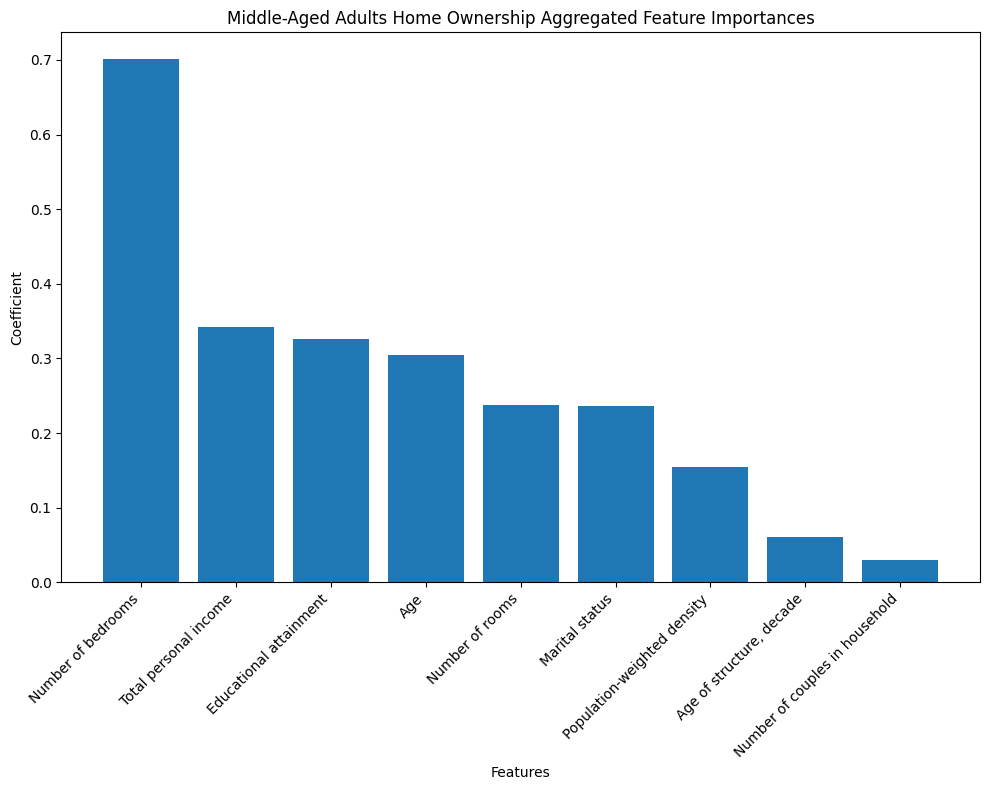

In [84]:
plt.figure(figsize=(10, 8))
plt.bar(sorted_grouped_importances.index, sorted_grouped_importances["AbsCoefficient"])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Middle-Aged Adults Home Ownership Aggregated Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Older Adults

In [85]:
X = df_older_adults.drop(columns=['Ownership of dwelling'])
y = df_older_adults['Ownership of dwelling']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Radial

In [86]:
svm_rbf = SVC(kernel="rbf", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.0001, 0.001, 0.01, 1, 10, 100]}
cv = GridSearchCV(
    svm_rbf,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_rbf = cv.best_params_["C"]
best_gamma = cv.best_params_["gamma"]
print(f"Radial CV results: C={best_C_rbf}, gamma={best_gamma}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Radial CV results: C=10, gamma=0.01
Train accuracy: 88.07%
Test accuracy: 87.06%


#### Poly

In [87]:
svm_poly = SVC(kernel="poly", tol=0.1)

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "degree": np.arange(2, 5, 1),
    "coef0": np.arange(0, 3, 0.5),
}
cv = GridSearchCV(
    svm_poly,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_poly = cv.best_params_["C"]
best_degree = cv.best_params_["degree"]
best_coef0 = cv.best_params_["coef0"]

print(f"Poly CV results: C={best_C_poly}, degree={best_degree}, coef0={best_coef0}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Poly CV results: C=1, degree=3, coef0=1.0
Train accuracy: 88.58%
Test accuracy: 87.06%


#### Linear

In [88]:
svm_linear = SVC(kernel="linear", tol=0.1) 

kFold = KFold(n_splits=5, shuffle=True, random_state=1)
params = {"C": [0.001, 0.01, 0.1, 1, 10]}
cv = GridSearchCV(
    svm_linear,
    param_grid=params,
    cv=kFold,
    refit=True,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)
cv.fit(X_train_scaled, y_train)

train_accuracy = cv.best_estimator_.score(X_train_scaled, y_train)
test_accuracy = cv.best_estimator_.score(X_test_scaled, y_test)

best_C_linear = cv.best_params_["C"]

print(f"Linear CV results: C={best_C_linear}")
print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Linear CV results: C=10
Train accuracy: 87.58%
Test accuracy: 87.10%


#### Feature Importance

In [89]:
coef = cv.best_estimator_.coef_[0]  # using linear kernel
feature_importances = pd.DataFrame({"Feature": X.columns, "Coefficient": coef, "AbsCoefficient": abs(coef)})
sorted_importances = feature_importances.sort_values(by="AbsCoefficient", ascending=False)

# sum up importances of onehot encoded features
grouped_importances = feature_importances.groupby(
    feature_importances["Feature"].str.split("_").str[0]
).sum()
sorted_grouped_importances = grouped_importances.sort_values(by="AbsCoefficient", ascending=False)

/var/folders/jy/pdgtcrw968d_3_tqfzr3w6y00000gn/T/ipykernel_84534/2379649311.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_importances = feature_importances.groupby(


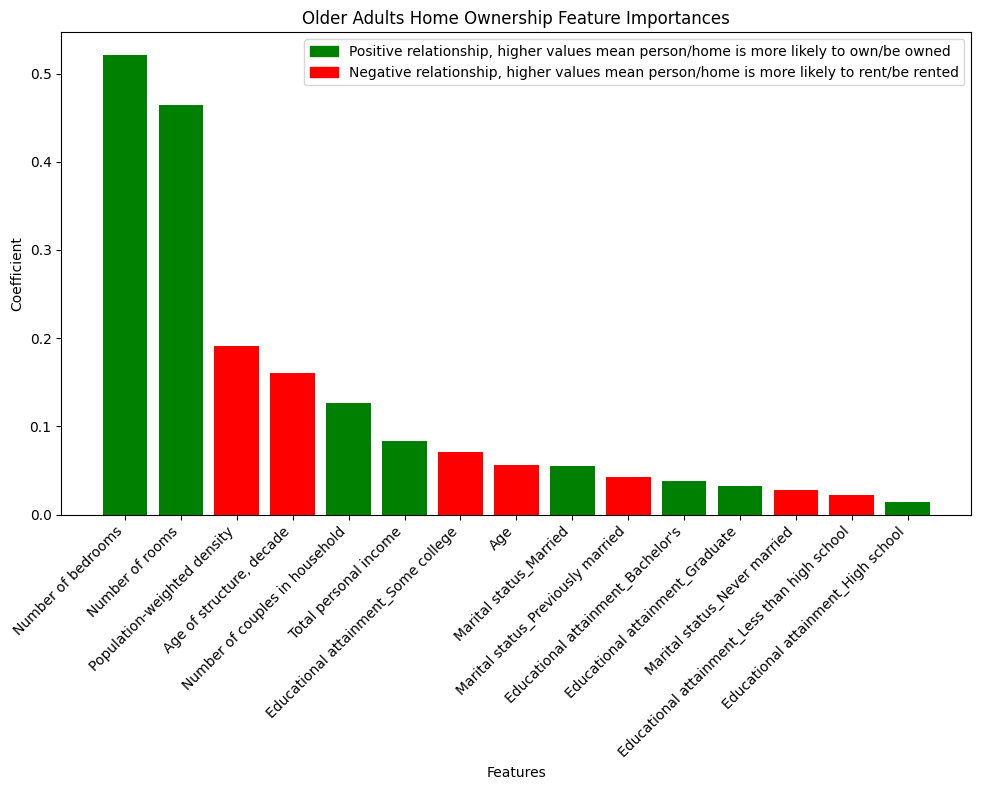

In [90]:
# color the bars based on coefficient sign
colors = ['green' if coef < 0 else 'red' for coef in sorted_importances["Coefficient"]]
green_patch = mpatches.Patch(color='green', label='Positive relationship, higher values mean person/home is more likely to own/be owned')
red_patch = mpatches.Patch(color='red', label='Negative relationship, higher values mean person/home is more likely to rent/be rented')

plt.figure(figsize=(10, 8))
plt.bar(sorted_importances['Feature'], sorted_importances["AbsCoefficient"], color=colors)
plt.legend(handles=[green_patch, red_patch])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Older Adults Home Ownership Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

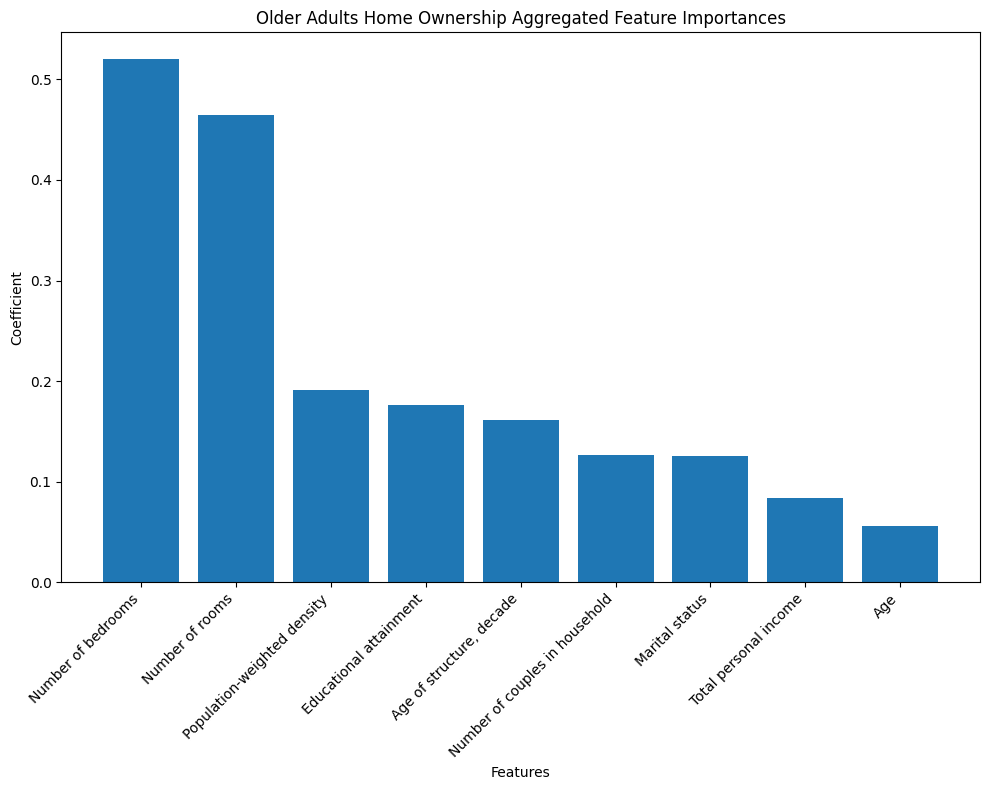

In [91]:
plt.figure(figsize=(10, 8))
plt.bar(sorted_grouped_importances.index, sorted_grouped_importances["AbsCoefficient"])
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Older Adults Home Ownership Aggregated Feature Importances")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Misc

### Prove 'Owned' was encoded as class 0 (to determine direction of relationship, i.e. negative coef == more likely to own)

In [92]:
encoder = LabelEncoder()
encoder.fit_transform(y)

print(encoder.classes_)

['Owned' 'Rented']


### 'Cartoon' plot for a simplified model using 2 strong predictors

In [106]:
X = df_young_adults[['Number of bedrooms', 'Total personal income']]
y = df_young_adults['Ownership of dwelling']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

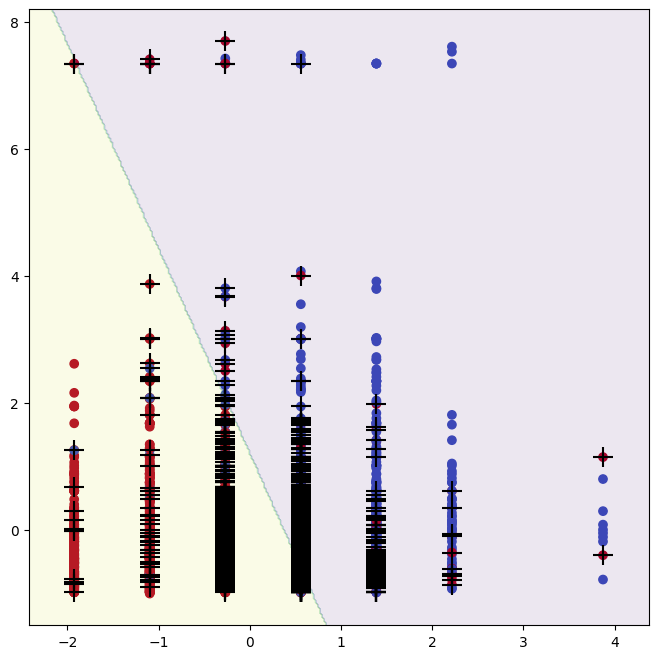

In [123]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

svm_linear = SVC(kernel="linear", C=0.01)
svm_linear.fit(X_train_scaled, y_train_encoded)

_, ax = plt.subplots(figsize=(8, 8))
plot_svm(
    X_train_scaled,
    y_train_encoded,
    svm_linear,
    ax=ax,
    scatter_cmap=plt.cm.coolwarm,
    decision_cmap=plt.cm.viridis,
    alpha=0.1
)